# Classification of NBA players role

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluting your notebook! Only the notebook file will be submitted, do not change the data filenames, file content or paths we'll use the provided ones.

Student name: <br>
ID Number:

### Dataset description

We will be working with a dataset of NBA basketball players data (you can get from https://www.kaggle.com/jacobbaruch/nba-player-of-the-week the full dataset).

The provided data is a subset of the full dataset containing the players that have the role of Center and of Point Guard. For each player the dataset contains the height, weight and age.

From Wikipedia:

The **Center** (C), also known as the five, or the big man, is one of the five positions in a regular basketball game. The center is normally the tallest player on the team, and often has a great deal of strength and body mass as well. In the NBA, the center is usually 6' 10" (2.08 m) or taller and usually weighs 240 lbs (109 kg) or more. 

**Point Guards** (PG, a.k.a. as "play maker") are expected to run the team's offense by controlling the ball and making sure that it gets to the right players at the right time. In the NBA, point guards are usually about 6' 3" (1.93 m) or shorter, and average about 6' 2" (1.88 m). Having above-average size (height, muscle) is considered advantageous, although size is secondary to situational awareness, speed, quickness, and ball handling skills. Shorter players tend to be better dribblers since they are closer to the floor, and thus have better control of the ball while dribbling. 


As it is clear from the description, the height and weight of the player are good hints to predict their role and in this lab we will exploit this features to estimate the role.


### Three features (regressors) are considered for this dataset:


1) Height in cm

2) Weight in kg

3) Age in years

We first import all the packages that are needed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv

import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

# Perceptron
We will implement the perceptron algorithm and use it to learn a halfspace.

**TO DO** Set the random seed (you can use your ID (matricola) or any other number!).

In [2]:
IDnumber = 1077515
np.random.seed(IDnumber)

Load the dataset and then split in training set and test set (the training set is typically larger, you can use a 75% tranining 25% test split) after applying a random permutation to the datset.

A) Load dataset and perform permutation

In [3]:
#load the dataset
filename = 'data/NBA.csv' # do not change the file name or content
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:4] #columns 1,2,3 contain the features
Y = dataset[:,0]  # column 0: labels

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m) # random permurtation

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


We are going to classify class "1" (Center) vs class "-1" (Point Guard)

B) **TO DO** Divide the data into training set and test set (3/4 of the data in the first set, 1/4 in the second one)

In [4]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

#m_training needs to be the number of samples in the training set
m_training = np.int(3*m/4)

#m_test needs to be the number of samples in the test set
m_test = np.int(m/4)

#X_training = instances for training set
X_training = X[:m_training, :]
#Y_training = labels for the training set
Y_training = Y[:m_training]

Y_ones = np.count_nonzero(Y_training > 0) #1 in Y_training
Y_minusones = np.count_nonzero(Y_training <= 0)  #-1 in Y_training
while Y_ones <= 10 or Y_minusones <= 10:  
    rand_perm = np.random.permutation(m)
    X = X[rand_perm]
    Y = Y[rand_perm]
    X_training = X[:m_training,:] 
    Y_training = Y[:m_training]
    Y_ones = np.count_nonzero(Y_training == 1)
    Y_minusones = np.count_nonzero(Y_training != 1)
else:
    print("Done")

#X_test = instances for test set
X_test =  X[m_training:,:]
#Y_test = labels for the test set
Y_test = Y[m_training:]

print(Y_training) #to make sure that Y_training contains both 1 and -1
print(m_test)

print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))

Done
[ 1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1  1  1
 -1  1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1  1  1
  1  1 -1  1  1 -1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1 -1  1 -1  1 -1
  1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1
  1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1
  1  1  1 -1  1  1 -1  1 -1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1
 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1
 -1  1  1]
65
Shape of training set: (195, 3)
Shape of test set: (65, 3)


**TO DO** Now add a 1 in front of each sample so that we can use a vector in homogeneous coordinates to describe all the coefficients of the model. You can use the function $hstack$ in $numpy$

In [5]:
#add a 1 to each sample (homogeneous coordinates)

ones_training = np.ones((m_training, 1))
ones_test=np.ones((m_test,1))
X_training_hom = np.hstack((ones_training, X_training))
X_test_hom = np.hstack((ones_test, X_test))

**TO DO** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where one iteration corresponds to one update of the perceptron weights. In case the termination is reached because the maximum number of iterations have been completed, the implementation should return **the best model** seen up to now.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model

In [6]:
def perceptron(X, Y, max_num_iterations):
    k = 0
    w = np.zeros(X.shape[1]) 
    best_w = np.zeros(X.shape[1])
    best_error = X.shape[0]
    while k <= max_num_iterations and best_error != 0:
        k += 1
        perm = np.random.permutation(X.shape[0])
        A = X[perm] 
        B = Y[perm]
        i = np.where(B*(A@w) <= 0)[0][0]
        w = w + B[i]*A[i,:]
        prediction = A @ w
        error = np.count_nonzero(B*prediction <= 0)   
        if error <= best_error:
            best_w = w
            best_error = error
        else:
            pass            
    
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [7]:
#now run the perceptron for 100 iterations
w_found, error = perceptron(X_training_hom,Y_training, 100)
print("Training Error of perpceptron (100 iterations): " + str(error/m_training))

Training Error of perpceptron (100 iterations): 0.08205128205128205


**TO DO** use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (the test error that is an estimate of the true loss).

In [8]:
#now use the w_found to make predictions on test dataset

num_errors = np.count_nonzero(Y_test * (X_test_hom @ w_found) <= 0)

true_loss_estimate = num_errors/m_test  # error rate on the test set
#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perpceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perpceptron (100 iterations): 0.06153846153846154


**TO DO** **[Answer the following]** What about the difference betweeen the training error and the test error  in terms of fraction of missclassified samples)? Explain what you observe. [Write the answer in this cell]

I expect to see a training error smaller than the test error. But I noticed that with some initial seeds it happens the opposite. 

**TO DO** Copy the code from the last 2 cells above in the cell below and repeat the training with 5000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [9]:
#now run the perceptron for 5000 iterations here!

w_found, error = perceptron(X_training_hom,Y_training, 5000)
print("Training Error of perpceptron (5000 iterations): " + str(error/m_training))

num_errors = np.count_nonzero(Y_test * (X_test_hom @ w_found) <= 0)

true_loss_estimate = num_errors/m_test  # error rate on the test set
#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perpceptron (5000 iterations): " + str(true_loss_estimate))

Training Error of perpceptron (5000 iterations): 0.08205128205128205
Test Error of perpceptron (5000 iterations): 0.07692307692307693


**TO DO** [Answer the following] What about the difference betweeen the training error and the test error  in terms of fraction of missclassified samples) when running for a larger number of iterations ? Explain what you observe and compare with the previous case. [Write the answer in this cell]

I noticed that the test error is the same, but the training error is lower for a larger number of iterations. Maybe this is due to some error fluctuations.

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [10]:
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA)
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:]
Y = dataset[:,0]

Y = Y*2-1  # set labels to {-1, 1} as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


**TO DO** As for the previous part, divide the data into training and test (75%-25%) and add a 1 as first component to each sample.

In [11]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.


m_training = np.int(3*m/4)
m_test = np.int(m/4)

X_training = X[:m_training, :]
Y_training = Y[:m_training]

Y_ones = np.count_nonzero(Y_training > 0) #1 in Y_training
Y_minusones = np.count_nonzero(Y_training <= 0)  #-1 in Y_training
while Y_ones <= 10 or Y_minusones <= 10:  
    rand_perm = np.random.permutation(m)
    X = X[rand_perm]
    Y = Y[rand_perm]
    X_training = X[:m_training,:] 
    Y_training = Y[:m_training]
    Y_ones = np.count_nonzero(Y_training == 1)
    Y_minusones = np.count_nonzero(Y_training != 1)
else:
    print("Done")


X_test =  X[m_training:,:]
Y_test = Y[m_training:]


Done


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [12]:
#part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5, solver='liblinear') #specified a solver to remove a warning

#learn from training set

logreg.fit(X_training, Y_training)


#predict on training set

Y_training_prediction = logreg.predict(X_training)


#print the error rate = fraction of missclassified samples
error_rate_training = np.count_nonzero(Y_training - Y_training_prediction !=0)

print("Error rate on training set: "+str(error_rate_training/m_training))

#predict on test set

Y_test_prediction = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 

error_rate_test = np.count_nonzero(Y_test - Y_test_prediction !=0)

print("Error rate on test set: " + str(error_rate_test/m_test))

Error rate on training set: 0.06666666666666667
Error rate on test set: 0.07692307692307693


**TO DO** Now pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test. Which features are you going to select ?

In [17]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

index_feature1 = 1
index_feature2 = 2
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

X_training = X_reduced[:m_training,:]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:,:]
Y_test = Y[m_training:]

Now learn a model using the training data and measure the performances.

In [18]:
# learning from training data

print("Features chosen: weight and age \n")

#learn from training set

logreg.fit(X_training, Y_training)

#predict on training set

Y_training_prediction = logreg.predict(X_training)


#print the error rate = fraction of missclassified samples
error_rate_training = np.count_nonzero(Y_training - Y_training_prediction !=0)

print("Error rate on training set: "+str(error_rate_training/m_training))

#predict on test set

Y_test_prediction = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 

error_rate_test = np.count_nonzero(Y_test - Y_test_prediction !=0)

print("Error rate on test set: " + str(error_rate_test/m_test))

Features chosen: weight and age 

Error rate on training set: 0.06153846153846154
Error rate on test set: 0.09230769230769231


In [19]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

index_feature1 = 0
index_feature2 = 2
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

X_training = X_reduced[:m_training,:]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:,:]
Y_test = Y[m_training:]

In [20]:
# learning from training data

#learn from training set

print("Features chosen: height and age \n")

logreg.fit(X_training, Y_training)

#predict on training set

Y_training_prediction = logreg.predict(X_training)


#print the error rate = fraction of missclassified samples
error_rate_training = np.count_nonzero(Y_training - Y_training_prediction !=0)

print("Error rate on training set: "+str(error_rate_training/m_training))

#predict on test set

Y_test_prediction = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 

error_rate_test = np.count_nonzero(Y_test - Y_test_prediction !=0)

print("Error rate on test set: " + str(error_rate_test/m_test))

Features chosen: height and age 

Error rate on training set: 0.28205128205128205
Error rate on test set: 0.26153846153846155


In [21]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

index_feature1 = 0
index_feature2 = 1
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

X_training = X_reduced[:m_training,:]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:,:]
Y_test = Y[m_training:]

In [22]:
# learning from training data

#learn from training set

print("Features chosen: height and weight \n")

logreg.fit(X_training, Y_training)

#predict on training set

Y_training_prediction = logreg.predict(X_training)


#print the error rate = fraction of missclassified samples
error_rate_training = np.count_nonzero(Y_training - Y_training_prediction !=0)

print("Error rate on training set: "+str(error_rate_training/m_training))

#predict on test set

Y_test_prediction = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 

error_rate_test = np.count_nonzero(Y_test - Y_test_prediction !=0)

print("Error rate on test set: " + str(error_rate_test/m_test))

Features chosen: height and weight 

Error rate on training set: 0.06666666666666667
Error rate on test set: 0.07692307692307693


**TO DO** [Answer the following] Which features did you select and why ? Compare the perfromances with the ones of the case with all the 3 features and comment about the results. [Write the answer in this cell]

I printed all the three possible combinations of features. As can be seen by the results printed above, the lower error on the training set is related to the choice of height and weight as features. The lower error on the test set is related to the choice of weight and age and also for the choice height and weight. Therefore the best choice of features seems to be the height and weight combination, as I would expect from the description of the two classes given at the beginning.
Note: for the feature pair height and age, the training error is higher than the test error and this is strange. I don't know if it is due to instability in the dataset or to errors in the code.

If everything is ok, the code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

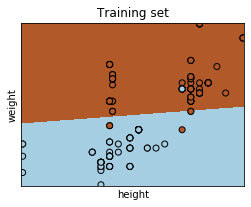

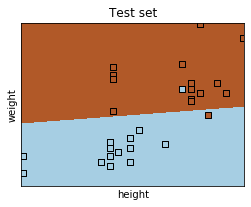

In [23]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

# NOTICE: This visualization code has been developed for a "standard" solution of the notebook, 
# it could be necessary to make some fixes to adapt to your implementation

h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_training[:, 0], X_training[:, 1], c=Y_training, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()